In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/darth/projects/master-thesis-code")

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from bopt.kernel_opt import plot_kernel_loss, plot_kernel_loss_2d
from bopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from bopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from bopt.bayesian_optimization import bo_plot_exploration, bo_maximize, Integer, Float
from bopt.bayesian_optimization import plot_2d_optim_result
from bopt.acquisition_functions import expected_improvement, probability_of_improvement
from bopt.bayesian_optimization import propose_location
from bopt.opt_functions import get_opt_test_functions
from bopt.plot import plot_gp

import GPy

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/util/config.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/defaults.cfg' mode='r' encoding='UTF-8'>
  config.readfp(open(default_file))
/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/util/datasets.py:58: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/util/data_resources.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()
/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/util/datasets.py:63: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/darth/projects/master-thesis-code/.venv/lib/python3.6/site-packages/GPy/util/football_teams.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()


In [3]:
import tensorflow as tf

tf.enable_eager_execution()

import tensorflow_probability as tfp


tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

In [13]:
kernel = psd_kernels.ExponentiatedQuadratic()
index_points = np.linspace(-1, 1, 100).reshape(-1, 1)

gp = tfd.GaussianProcess(kernel, index_points)

In [14]:
samples = gp.sample(10)

In [16]:
noisy_gp = tfd.GaussianProcess(kernel, index_points, observation_noise_variance=0.05)

In [17]:
noisy_samples = noisy_gp.sample(10)

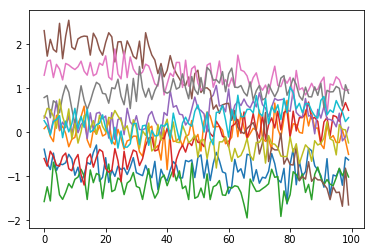

In [19]:
plt.plot(noisy_samples.numpy().T)
plt.show()

In [36]:
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observed_index_points = np.expand_dims(np.random.uniform(-1., 1., 50), -1)
observed_values = f(observed_index_points)

In [69]:
x = tf.Variable(1., dtype=tf.float64)

with tf.GradientTape() as t:
    t.watch(x)
    
    y = x*x + x*3 + 4

In [70]:
t.gradient(y, x)

<tf.Tensor: id=3495, shape=(), dtype=float64, numpy=5.0>

In [109]:
optimizer = tf.train.AdamOptimizer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, nll_ = sess.run([optimize, nll])
    
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, nll_))
            
    print("Final NLL = {}".format(nll_))

RuntimeError: `loss` passed to Optimizer.compute_gradients should be a function when eager execution is enabled.

Step 0: NLL = 6566092.802266406
Step 100: NLL = 4695579.374576537
Step 200: NLL = 2425294.192500413
Step 300: NLL = 1603530.1832759993
Step 400: NLL = 1041550.626946783
Step 500: NLL = 426189.8012769013
Step 600: NLL = 148353.88487425205
Step 700: NLL = 73587.65906577937
Step 800: NLL = 43944.568785499454
Step 900: NLL = 28891.176669099947
1.3780245204771155 0.4520673229852691


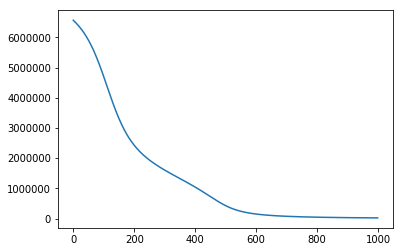

In [128]:

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
optimizer = tf.train.AdamOptimizer()

length_scale = tf.Variable(1., dtype=tf.float64)
amplitude = tf.Variable(1., dtype=tf.float64)
variables = [amplitude, length_scale]


ll = []

for i in range(1000):
    with tf.GradientTape() as t:
        kernel = psd_kernels.ExponentiatedQuadratic(length_scale=length_scale, amplitude=amplitude)
        gp = tfd.GaussianProcess(kernel, observed_index_points)
        neg_log_likelihood = -gp.log_prob(observed_values)

    grad = t.gradient(neg_log_likelihood, variables)

    optimizer.apply_gradients(zip(grad, variables))

    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood))
    ll.append(neg_log_likelihood)
    
plt.plot(ll)
print(amplitude.numpy(), length_scale.numpy())

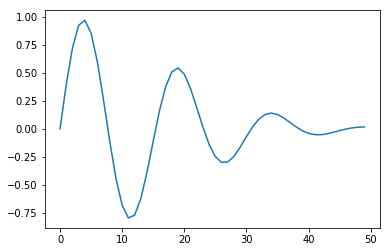

In [33]:
plt.plot(f(np.linspace(0,2).reshape(-1, 1)))

## Broken kernel


In [55]:
noise = 1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])

X_train = np.array([2,2.01,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5])

# X_train = np.array([2,2.01,2.02,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
# y_train = np.array([2,3,2,100])


# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01)

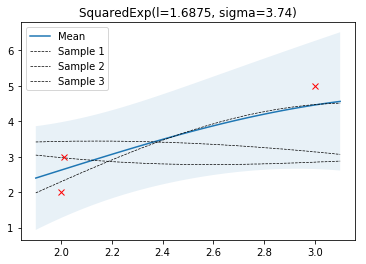

In [60]:
GaussianProcess(noise=noise, kernel=SquaredExp()).fit(X_train, y_train)\
    .optimize_kernel().posterior(X).plot_posterior(figure=False, num_samples=3)

# Sklearn

1.6874958008633578 3.7416889765237173


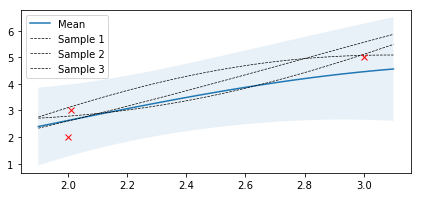

In [57]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

mu_s, cov_s = gpr.predict(X.reshape(-1, 1), return_cov=True)

l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print(l, sigma_f)

plot_gp(mu_s.reshape(-1), cov_s, X, X_train, y_train, num_samples=3)

# GPy

1.558718823156938 3.844799807952887   index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.48324855  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x122ea40f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x122ea4048>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x122ea45c0>]}

 /Users/arnoljak/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


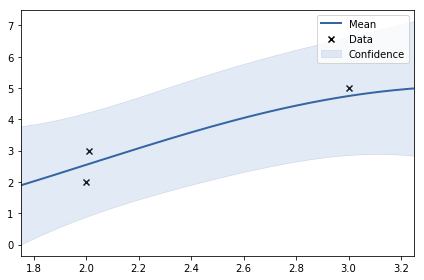

In [63]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), rbf)

gpr.Gaussian_noise.variance = noise**2
# gpr.Gaussian_noise.variance.fix()

gpr.optimize()

l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])
print(l, sigma_f, gpr.Gaussian_noise.variance)

gpr.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x122a709b0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x122a70908>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x122a70e48>]}

 /Users/arnoljak/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


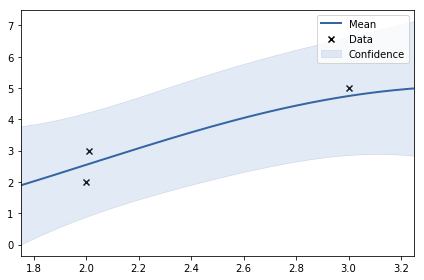

In [59]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
# kernel = GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)

m = GPy.models.GPRegression(X_train.reshape(-1,1),y_train.reshape(-1, 1),kernel)
m.optimize(messages=True)
m.plot()

In [54]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[4309.89309856, 4309.26915992, 4307.39788592, 1013.20537232],
       [4309.26915992, 4309.89309856, 4309.26915992, 1042.82152586],
       [4307.39788592, 4309.26915992, 4309.89309856, 1072.99262478],
       [1013.20537232, 1042.82152586, 1072.99262478, 4309.89309856]])

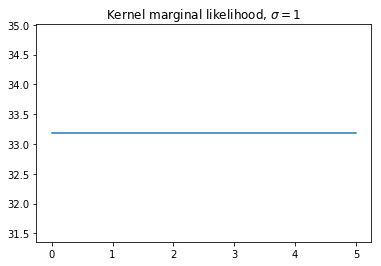

In [8]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

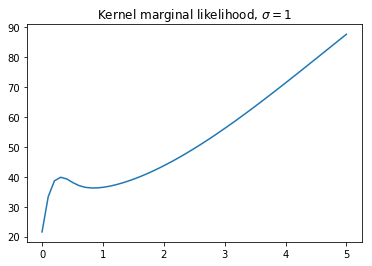

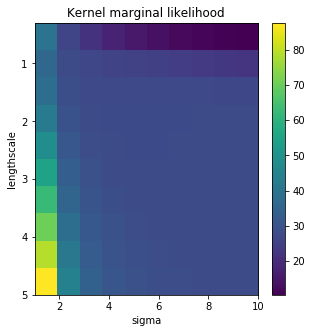

In [9]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

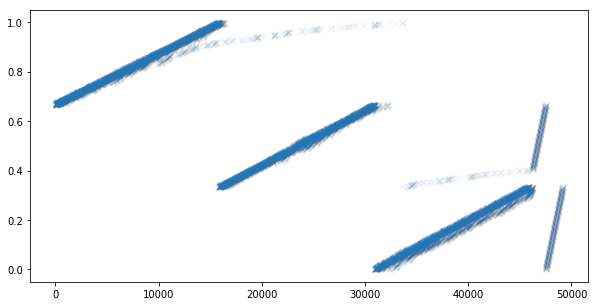

In [68]:
values = np.genfromtxt("data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [69]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [72]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


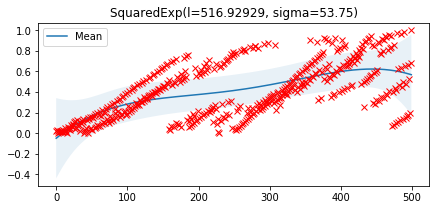

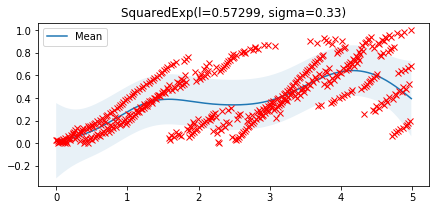

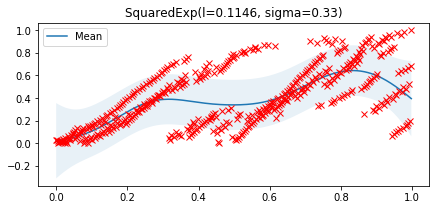

In [73]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
%prun foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

In [176]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

AttributeError: 'numpy.ndarray' object has no attribute 'set_params'

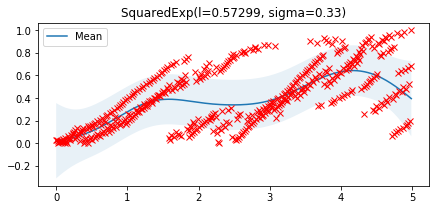

In [5]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

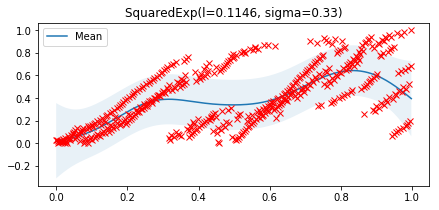

In [6]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

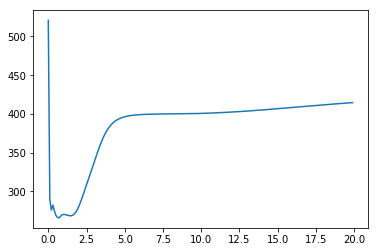

In [7]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

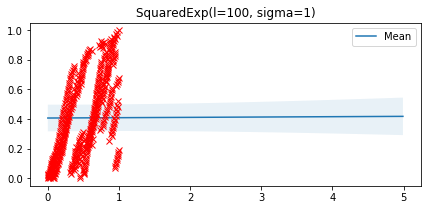

In [8]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)